Resource used for this notebook: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [19]:
import os.path
import re
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    text=""
    with open( os.path.join(path, file_name),"r", encoding="utf8") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [11]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english')+["http"])
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [5]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [6]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [7]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [8]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [17]:
def removeFromText(pattern, series, space=""):
    return series.apply(lambda s: re.sub(pattern, space, str(s) ))

In [27]:
def cleanText(df):
    patternLinks = "http.*"
    patternAts = "@.*"
    patternNewLine = "\n"
    df['text'] = removeFromText(patternLinks, df['text'])
    df['text'] = removeFromText(patternAts, df['text'])
    df['text'] = removeFromText(patternNewLine, df['text'], " ")

# With Gensim

In [15]:
def model(tweets, words=8, number_of_topics=3):
    model=create_gensim_lsa_model(tweets,number_of_topics,words)

In [9]:
df3 = pd.read_csv("thirdpull_earlyLockdown.csv")
df3 = df3.dropna()

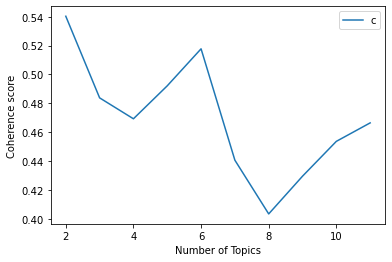

In [21]:
tweets = preprocess_data(df3['text'])
start,stop,step=2,12,1
plot_graph(tweets,start,stop,step)

In [24]:
model(tweets, 10, 6)

[(0, '-0.821*"coronaviru" + -0.237*"case" + -0.147*"test" + -0.118*"trump" + -0.111*"us" + -0.106*"new" + -0.105*"peopl" + -0.092*"itali" + -0.088*"000" + -0.080*"china"'), (1, '0.498*"19" + 0.475*"covid" + 0.247*"test" + -0.245*"coronaviru" + 0.238*"trump" + 0.181*"posit" + 0.133*"day" + 0.118*"sinc" + 0.116*"quarantin" + 0.106*"ago"'), (2, '-0.391*"case" + 0.361*"test" + -0.299*"19" + -0.252*"covid" + 0.247*"posit" + 0.197*"day" + 0.188*"quarantin" + -0.178*"new" + 0.167*"ago" + 0.163*"self"'), (3, '-0.526*"case" + -0.310*"new" + 0.216*"coronaviru" + 0.203*"trump" + -0.192*"5" + 0.160*"covid" + -0.143*"ago" + -0.143*"tonight" + -0.139*"quarantin" + -0.137*"6"'), (4, '0.346*"30" + 0.310*"us" + -0.248*"trump" + 0.222*"death" + -0.196*"case" + 0.192*"22" + 0.192*"china" + 0.178*"itali" + 0.177*"south" + 0.174*"korea"'), (5, '0.632*"trump" + -0.173*"19" + -0.169*"covid" + 0.165*"us" + 0.154*"30" + -0.152*"coronaviru" + 0.140*"presid" + 0.133*"day" + 0.120*"matt" + 0.120*"gaetz"')]


In [26]:
df4 = pd.read_csv("fourthpull_midLockdown.csv")
df4 = df3.dropna()

In [28]:
cleanText(df4)

<ipython-input-27-bceee8476320>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = removeFromText(patternLinks, df['text'])
<ipython-input-27-bceee8476320>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = removeFromText(patternAts, df['text'])
<ipython-input-27-bceee8476320>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

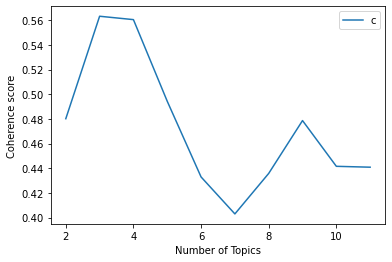

In [29]:
tweets = preprocess_data(df4['text'])
start,stop,step=2,12,1
plot_graph(tweets,start,stop,step)

In [31]:
model(tweets, 10, 4)

[(0, '-0.794*"coronaviru" + -0.163*"case" + -0.163*"us" + -0.160*"trump" + -0.146*"test" + -0.117*"itali" + -0.111*"peopl" + -0.098*"30" + -0.097*"day" + -0.087*"new"'), (1, '-0.332*"test" + 0.239*"30" + 0.228*"itali" + -0.203*"day" + -0.202*"posit" + -0.196*"trump" + 0.187*"case" + -0.176*"quarantin" + 0.169*"6" + 0.156*"spain"'), (2, '0.467*"covid" + 0.461*"19" + -0.285*"coronaviru" + 0.197*"test" + 0.183*"pleas" + 0.179*"keep" + 0.142*"posit" + 0.123*"us" + 0.122*"safe" + 0.119*"case"'), (3, '0.279*"covid" + 0.263*"19" + -0.246*"30" + 0.205*"coronaviru" + -0.188*"test" + -0.168*"quarantin" + -0.160*"5" + -0.158*"posit" + -0.157*"day" + -0.157*"death"')]


# Now with Sklearn

Resource: https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf

In [33]:
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy

In [34]:
stopwords = set(stopwords.words('english')+["http"])

In [36]:
vectorizer = CountVectorizer(min_df=1, stop_words=stopwords)
docTermMatrix = vectorizer.fit_transform(df3['text'])
dtm = pd.DataFrame(docTermMatrix.toarray(), index=df3['text'], columns=vectorizer.get_feature_names())

In [38]:
dtm.head()

,00,000,10,100,100k,11,115,12,14,15,...,would,wrong,wrote,wuhan,yeah,year,years,yesterday,yet,york
text,,,,,,,,,,,,,,,,,,,,,
Coronavirus deaths China: 3119 Italy: 463 Iran: 237 South Korea: 53 France: 30 Spain: 30 US: 22 Japan: 17 Iraq: 6…,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The mob boss doesn't want an accurate count of the #coronavirus because it will make the stock market plummet. We c…,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Schumer: What was glaringly missing from President Trump’s press conference was how he is actually going to combat…,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
All of Italy is in lockdown as coronavirus cases rise,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Where SVD comes in...

In [ ]:
lsa = TruncatedSVD(100, algorithm='randomized')
dtm_lsa = lsa.fit_transorm(docTermMatrix) # From doc: Fit model to X and perform dimensionality reduction on X.
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa) #Normalizes samples to unit norm

"Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community." - sklearn documenation for Normalizer